An example of the effects of similarity thresholding, implemented in python.

In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# PDHG method implementation
def pdhg_method(primal_gradient, dual_gradient, x0, y0, tau, sigma, max_iter=1000, tol=1e-8):
    """
        Primal-Dual Hybrid Gradient (PDHG) method.
    """
    x = x0
    y = y0
    x_iterates = [x]
    y_iterates = [y]
    x_iterates_plotting = [x]
    y_iterates_plotting = [y]

    x_averages = [x]
    y_averages = [y]

    for k in range(max_iter):
        
        # Primal update:
        x_next = x - tau * primal_gradient(x, y)
        # Dual update:
        y_next = y + sigma * dual_gradient(2 * x_next - x, y)

        # Save the iterates:
        x_iterates.append(x_next)
        y_iterates.append(y_next)
        x_iterates_plotting.append(x_next)
        y_iterates_plotting.append(y_next)

        # Compute the averages:
        x_average = np.mean(x_iterates, axis=0)
        y_average = np.mean(y_iterates, axis=0)
        x_averages.append(x_average)
        y_averages.append(y_average)

        # Check convergence
        if np.linalg.norm(x_next - 0) < tol and np.linalg.norm(y_next - 0) < tol:
            print(f"Converged in {k} iterations.")
            break
        
        # Restarting to the average every 25 iterations:
        if k % 25 == 0 and k != 0:
            x_next = x_average
            y_next = y_average
            x_iterates = [x_average]
            y_iterates = [y_average]

        x, y = x_next, y_next

    return x, y, x_iterates_plotting, y_iterates_plotting, x_averages, y_averages


In [3]:
# PDHG method implementation
def pdhg_stn_method(primal_gradient, dual_gradient, x0, y0, tau, sigma, sim_threshold=0.8, momentum_coefficient = 0.3, max_iter=1000, tol=1e-8):
    """
        PDHG+STN for solving saddle-point problems.
    """
    x = x0
    y = y0
    prev_delta_x = 0
    prev_delta_y = 0

    x_iterates = [x]
    y_iterates = [y]
    x_iterates_plotting = [x]
    y_iterates_plotting = [y]

    x_averages = [x]
    y_averages = [y]

    similiarity_iterates = []
    similarity = 0
    restarted = False

    for k in range(max_iter):
        
        if similarity >= sim_threshold:
            # Add Nesterov momentum
            x_hat = x + prev_delta_x * momentum_coefficient
            y_hat = y + prev_delta_y * momentum_coefficient
        else:
            y_hat = y
            x_hat = x
        
        # Primal update:
        x_next = x_hat - tau * primal_gradient(x_hat, y_hat)

        # Dual update:
        y_next = y_hat + sigma * dual_gradient(2 * x_next - x_hat, y_hat)

        # Calculate the difference:
        delta_x = x_next - x
        delta_y = y_next - y

        # Calculating the similarity:
        if k == 0 or restarted:
            similarity = 0
        else:
            norm_prev = ((prev_delta_x ** 2) + (prev_delta_y ** 2))**(0.5)
            norm_cur = ((delta_x ** 2) + (delta_y ** 2))**(0.5)
            similarity = prev_delta_x * delta_x + prev_delta_y * delta_y / (norm_cur * norm_prev)
        similiarity_iterates.append(similarity)
        
        # Save the iterates:
        x_iterates.append(x_next)
        y_iterates.append(y_next)
        x_iterates_plotting.append(x_next)
        y_iterates_plotting.append(y_next)

        # Compute the averages:
        x_average = np.mean(x_iterates, axis=0)
        y_average = np.mean(y_iterates, axis=0)
        x_averages.append(x_average)
        y_averages.append(y_average)

        # Check convergence
        if np.linalg.norm(x_next - 0) < tol and np.linalg.norm(y_next - 0) < tol:
            print(f"Converged in {k} iterations.")
            break

        # Restarting to the average every 25 iterations:
        if k % 25 == 0 and k != 0:
            x_next = x_average
            y_next = y_average
            x_iterates = [x_average]
            y_iterates = [y_average]
            delta_x = 0
            delta_y = 0
            similarity = 0
            restarted = True
        else:
            restarted = False

        prev_delta_x = delta_x
        prev_delta_y = delta_y
        x, y = x_next, y_next

    return x, y, x_iterates_plotting, y_iterates_plotting, x_averages, y_averages, similiarity_iterates

PDHG Solution: x = 0.05977738910467638, y = 0.10558303693769606
PDHG+STN Solution: x = 0.022942809756111474, y = 0.06709099558109602


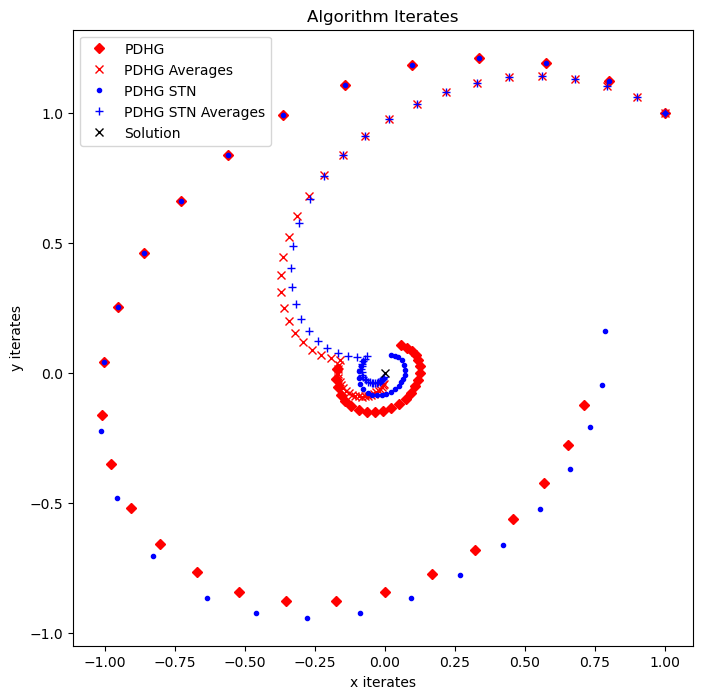

In [4]:
# Defining the primal and dual gradients for the problem L(x,y) = xy
def primal_gradient(x, y):
    return y

def dual_gradient(x, y):
    return x 

# Initial values
x0 = 1.0
y0 = 1.0
tau = 0.2
sigma = 0.2

# Solve using PDHG
x_sol, y_sol, x_iterates, y_iterates, x_averages, y_averages = pdhg_method(primal_gradient, dual_gradient, x0, y0, tau, sigma, 49)

# Solve using the PDHG STP method
(x_sol_stn, y_sol_stn, x_iterates_stn, y_iterates_stn, 
 x_averages_stn, y_averages_stn, similarity_iterates) = pdhg_stn_method(primal_gradient, dual_gradient, x0, y0, tau, sigma, 0.8, 0.3, 49)

print(f"PDHG Solution: x = {x_sol}, y = {y_sol}")
print(f"PDHG+STN Solution: x = {x_sol_stn}, y = {y_sol_stn}")

# Plotting the iterates:
plt.figure(figsize=(8, 8))
# Plot the iterates and averages
plt.plot(x_iterates, y_iterates, 'rD', markersize=5, label='PDHG')
plt.plot(x_averages, y_averages, 'rx', label='PDHG Averages')
plt.plot(x_iterates_stn, y_iterates_stn, 'bo', markersize=3, label='PDHG STN')
plt.plot(x_averages_stn, y_averages_stn, 'b+', label='PDHG STN Averages')

plt.plot(0, 0, 'kx', label='Solution')
plt.legend()
plt.title('Algorithm Iterates')
plt.xlabel('x iterates')
plt.ylabel('y iterates');

In [5]:
# Outputting the data to .dat files for plotting in LaTeX:
np.savetxt('plotting_data/visual_example/pdhg.dat', np.array([x_iterates, y_iterates]).T, delimiter=' ')
np.savetxt('plotting_data/visual_example/pdhg_averages.dat', np.array([x_averages, y_averages]).T, delimiter=' ')
np.savetxt('plotting_data/visual_example/pdhg_stn.dat', np.array([x_iterates_stn, y_iterates_stn]).T, delimiter=' ')
np.savetxt('plotting_data/visual_example/pdhg_stn_averages.dat', np.array([x_averages_stn, y_averages_stn]).T, delimiter=' ')

In [6]:
def gradient_descent(primal_gradient, x0, y0, tau, max_iter=1000, tol=1e-8):
    x = x0
    y = y0
    x_iterates = [x]
    y_iterates = [y]

    for k in range(max_iter):
        # Update step:
        (grad_x, grad_y) = primal_gradient(x, y)
        x_next = x - tau * grad_x
        y_next = y - tau * grad_y

        # Save the iterates:
        x_iterates.append(x_next)
        y_iterates.append(y_next)

        # Check convergence
        if np.linalg.norm([x_next - 1, y_next - 1]) < tol:
            print(f"Converged in {k} iterations.")
            break

        x = x_next
        y = y_next

    return x, y, x_iterates, y_iterates

In [12]:
def gradient_descent_stn(primal_gradient, x0, y0, tau, momentum_coefficient, similarity_threshold, max_iter=1000, tol=1e-8):
    x = x0
    y = y0
    x_iterates = [x]
    y_iterates = [y]
    x_hat_iterates = []
    y_hat_iterates = []
    
    prev_delta_x = 0
    prev_delta_y = 0
    similarity_iterates = []
    similarity = 0

    for k in range(max_iter):
        
        # Update step:
        if similarity >= similarity_threshold:
            # Add Nesterov momentum
            x_hat = x + prev_delta_x * momentum_coefficient
            y_hat = y + prev_delta_y * momentum_coefficient
        else:
            y_hat = y
            x_hat = x
        
        # Save the hat iterates:
        x_hat_iterates.append(x_hat)
        y_hat_iterates.append(y_hat)

        (grad_x, grad_y) = primal_gradient(x_hat, y_hat)
        x_next = x_hat - tau * grad_x
        y_next = y_hat - tau * grad_y

        # Save the iterates:
        x_iterates.append(x_next)
        y_iterates.append(y_next)

        # Calculate the difference:
        delta_x = x_next - x
        delta_y = y_next - y

        # Calculating the similarity:
        if k == 0:
            similarity = 0
        else:
            norm_prev = ((prev_delta_x ** 2) + (prev_delta_y ** 2))**(0.5)
            norm_cur = ((delta_x ** 2) + (delta_y ** 2))**(0.5)
            similarity = prev_delta_x * delta_x + prev_delta_y * delta_y / (norm_cur * norm_prev)
        similarity_iterates.append(similarity)

        # Check convergence
        if np.linalg.norm([x_next - 1, y_next - 1]) < tol:
            print(f"Converged in {k} iterations.")
            break

        (prev_delta_x, prev_delta_y) = (delta_x, delta_y)
        (x, y) = (x_next, y_next)

    return x_iterates, y_iterates, similarity_iterates, x_hat_iterates, y_hat_iterates

In [78]:
def gradient_descent_stp(primal_gradient, x0, y0, tau, momentum_coefficient, similarity_threshold, max_iter=1000, tol=1e-8):
    x = x0
    y = y0
    x_iterates = [x]
    y_iterates = [y]
    x_hat_iterates = [x]
    y_hat_iterates = [y]

    prev_delta_x = 0
    prev_delta_y = 0
    similarity_iterates = []
    similarity = 0

    for k in range(max_iter):        
        # Update step:
        (grad_x, grad_y) = primal_gradient(x, y)
        x_next = x - tau * grad_x
        y_next = y - tau * grad_y

        # Calculate the difference:
        delta_x = x_next - x
        delta_y = y_next - y

        # Calculating the similarity:
        if k == 0:
            similarity = 0
        else:
            norm_prev = ((prev_delta_x ** 2) + (prev_delta_y ** 2))**(0.5)
            norm_cur = ((delta_x ** 2) + (delta_y ** 2))**(0.5)
            similarity = prev_delta_x * delta_x + prev_delta_y * delta_y / (norm_cur * norm_prev)
        similarity_iterates.append(similarity)

        # Save the iterates:
        x_iterates.append(x_next)
        y_iterates.append(y_next)

        # Add Similarity thresholded Polyak momentum:
        if similarity >= similarity_threshold:
            x_next = x_next + prev_delta_x * momentum_coefficient
            y_next = y_next + prev_delta_y * momentum_coefficient
        
            # Calculate the new differences:
            delta_x = x_next - x
            delta_y = y_next - y

        # Save the hat iterates:
        x_hat_iterates.append(x_next)
        y_hat_iterates.append(y_next)

        # Check convergence
        if np.linalg.norm([x_next - 1, y_next - 1]) < tol:
            print(f"Converged in {k} iterations.")
            break

        (prev_delta_x, prev_delta_y) = (delta_x, delta_y)
        (x, y) = (x_next, y_next)

    return x_iterates, y_iterates, similarity_iterates, x_hat_iterates, y_hat_iterates

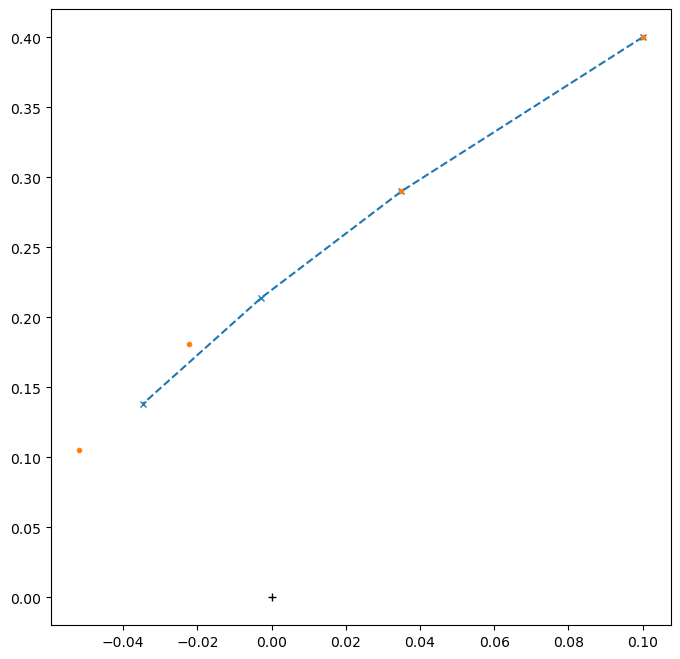

In [81]:
# A simple example for visualizing the difference between different acceleration schemes:
def primal_gradient(x, y):
    return (5*x + 2*y, 5*y + 2*x)


# Initial values
x0 = 0.1
y0 = 0.4
# Step size
tau = 0.05
# Mometum coefficient: 
kappa = 0.3
# Termination criteria:
MAX_ITERS = 3
tolerance = 1e-8

# Solve using gradient descent + polyak momentum
polyak_x_iterates, polyak_y_iterates, _, polyak_x_hat_iterates, polyak_y_hat_iterates  = gradient_descent_stp(
    primal_gradient, x0, y0, tau, kappa, -1.1, max_iter=MAX_ITERS, tol=tolerance,
)
# Solve using gradient descent + nesterov momentum


# Plotting the iterates:
plt.figure(figsize=(8, 8))
plt.plot(polyak_x_iterates, polyak_y_iterates, 'x--', markersize=5, label='Polyak')
plt.plot(polyak_x_hat_iterates, polyak_y_hat_iterates, 'o', markersize=3, label='Polyak Hat')
plt.plot(0, 0, 'k+', label='Solution')

In [9]:
# Defining the primal and dual gradients for the Rosenbrock problem F(x_1,x_2) = (1 - x_1)^2 + 100*(x_2 - x_1^2)^2
def primal_gradient(x, y):
    a = 1
    b = 100
    return (2 * (x - a) - 4 * b * x * (y - x**2), 2 * b * (y - x**2))


# Initial values
x0 = -1
y0 = -1
# Step size
tau = 0.001

# # Solve using GD+P
# _, _, x_iterates_p, y_iterates_p, _ = gradient_descent_stp(
#     primal_gradient, x0, y0, tau, 0.85, -1.1, 100000, tol=1e-8
# )  # Best kappa = 0.85


# # Solve using GD+N
# _, _, x_iterates_n, y_iterates_n, _ = gradient_descent_stn(
#     primal_gradient, x0, y0, tau, 0.90, -1.1, 100000, tol=1e-8
# )  # Best kappa = 0.90

# # Solve using GD+STP
# _, _, x_iterates_stp, y_iterates_stp, _ = gradient_descent_stp(
#     primal_gradient, x0, y0, tau, 1, 0.1, 100000, tol=1e-8
# )

# # Solve using GD+STN
# _, _, x_iterates_stn, y_iterates_stn, _ = gradient_descent_stn(
#     primal_gradient, x0, y0, tau, 0.95, 0.3, 100000, tol=1e-8
# )



In [10]:
# Plotting the convergence of the iterates:
distances_n = [
    np.linalg.norm([x - 1, y - 1]) for (x, y) in zip(x_iterates_n, y_iterates_n)
]
distances_stn = [
    np.linalg.norm([x - 1, y - 1]) for (x, y) in zip(x_iterates_stn, y_iterates_stn)
]
distances_p = [
    np.linalg.norm([x - 1, y - 1]) for (x, y) in zip(x_iterates_p, y_iterates_p)
]
distances_stp = [
    np.linalg.norm([x - 1, y - 1]) for (x, y) in zip(x_iterates_stp, y_iterates_stp)
]

plt.figure(figsize=(8, 8))

# Plotting only 100 data points for every method:
# Selecting evenly spaced points for plotting:
datapoints = 50
indices_n = np.linspace(0, len(distances_n) - 1, datapoints, dtype=int)
indices_stn = np.linspace(0, len(distances_stn) - 1, datapoints, dtype=int)
indices_p = np.linspace(0, len(distances_p) - 1, datapoints, dtype=int)
indices_stp = np.linspace(0, len(distances_stp) - 1, datapoints, dtype=int)

distances_n_sampled = [distances_n[i] for i in indices_n]
distances_stn_sampled = [distances_stn[i] for i in indices_stn]
distances_p_sampled = [distances_p[i] for i in indices_p]
distances_stp_sampled = [distances_stp[i] for i in indices_stp]

plt.plot(indices_n, distances_n_sampled, ".--", label="GD+N")
plt.plot(indices_stn, distances_stn_sampled, ".--", label="GD+STN")
plt.plot(indices_p, distances_p_sampled, ".--", label="GD+P")
plt.plot(indices_stp, distances_stp_sampled, ".--", label="GD+STP")

plt.legend()
plt.title("Effects of Similarity Thresholding on the Rosenbrock Problem")
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Distance to solution");


NameError: name 'x_iterates_n' is not defined

In [ ]:
# Saving the data in .dat files for plotting in LaTeX:
np.savetxt('plotting_data/rosenbrock/polyak.dat', np.array([indices_p, distances_p_sampled]).T, delimiter=' ')
np.savetxt('plotting_data/rosenbrock/st_polyak.dat', np.array([indices_stp, distances_stp_sampled]).T, delimiter=' ')
np.savetxt('plotting_data/rosenbrock/nesterov.dat', np.array([indices_n, distances_n_sampled]).T, delimiter=' ')
np.savetxt('plotting_data/rosenbrock/st_nesterov.dat', np.array([indices_stn, distances_stn_sampled]).T, delimiter=' ')

Converged in 3113 iterations.
Converged in 3113 iterations.


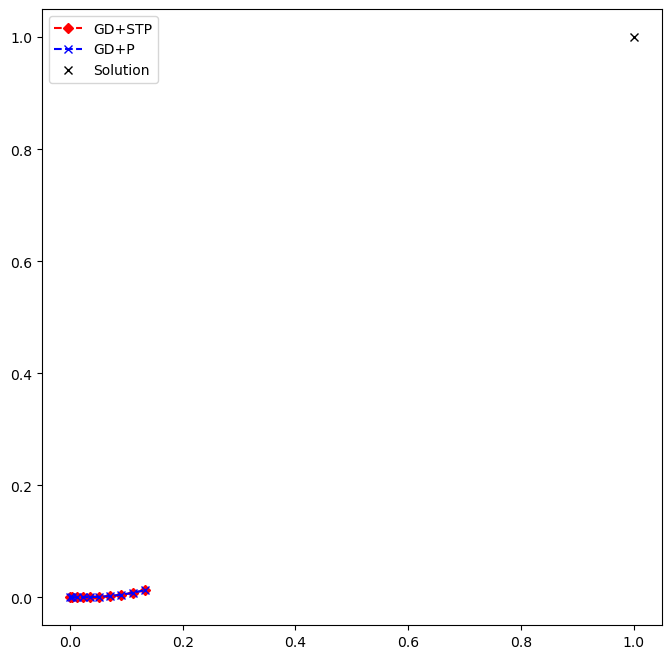

In [ ]:
# Solve uting GD+STP and GD+P
(x0, y0) = (0, 0)
tau = 0.002
_, _, x_iterates_stp, y_iterates_stp, _ = gradient_descent_stp(
    primal_gradient, x0, y0, tau, 0.9, -0.1, 40000, tol=1e-12
)

_, _, x_iterates_p, y_iterates_p, _ = gradient_descent_stp(
    primal_gradient, x0, y0, tau, 0.9, -1.1, 40000, tol=1e-12
)

start_wind = 0
end_wind = 10
plt.figure(figsize=(8, 8))
plt.plot(x_iterates_stp[start_wind:end_wind], y_iterates_stp[start_wind:end_wind], 'rD--', markersize=5, label='GD+STP')
plt.plot(x_iterates_p[start_wind:end_wind], y_iterates_p[start_wind:end_wind], 'bx--', label='GD+P')
plt.plot(1, 1, 'kx', label='Solution')
plt.legend()


In [ ]:
(x0, y0) = (-100, -1)
tau = 0.001
# Solve using GD+N
_, _, _, _, _ = gradient_descent_stn(
    primal_gradient, x0, y0, tau, 0.90, -1.1, 1000000, tol=1e-4
)
# Solve using GD+STN
_, _, _, _, _ = gradient_descent_stn(
    primal_gradient, x0, y0, tau, 0.95, 0.0, 1000000, tol=1e-4
) # results in solve in 2774 iterations, ST allows for larger momentum term. 

114
81
79
101
83
101


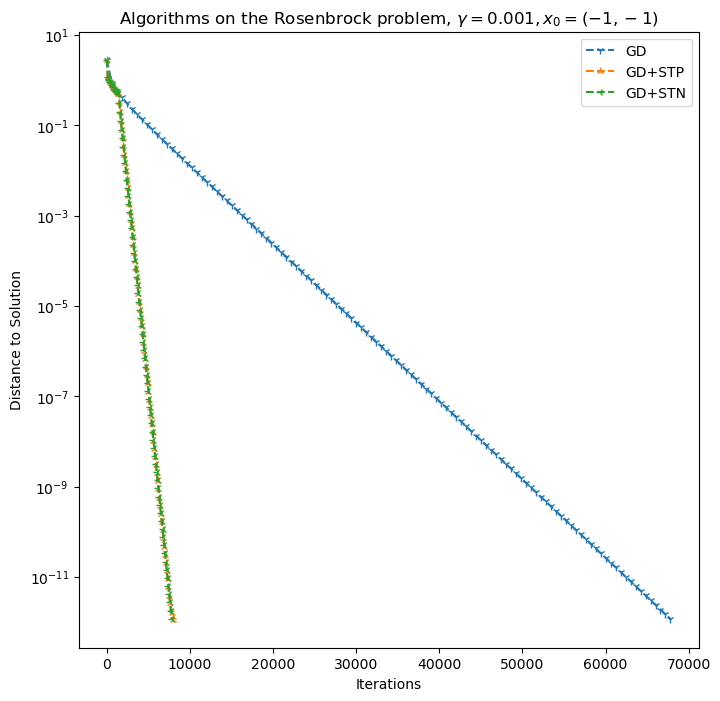

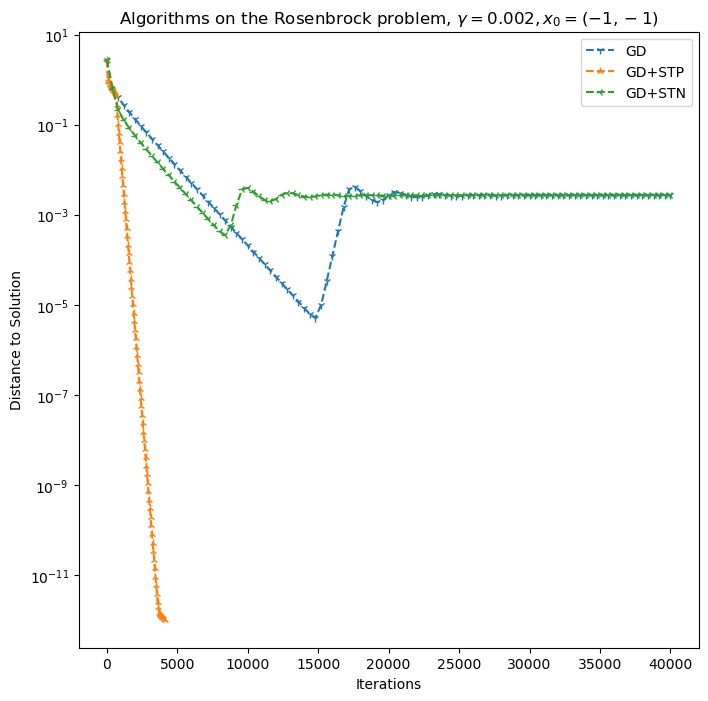

In [ ]:
# Selecting evenly spaced points for plotting:
index_distances_gd_01_spaced = np.arange(0, len(distances_gd_01), 600)
distances_gd_01_spaced = distances_gd_01[::600]
index_distances_gd_stp_01_spaced = np.arange(0, len(distances_gd_stp_01), 100)
distances_gd_stp_01_spaced = distances_gd_stp_01[::100]
index_distances_gd_stn_01_spaced = np.arange(0, len(distances_gd_stn_01), 100)
distances_gd_stn_01_spaced = distances_gd_stn_01[::100]

index_distances_gd_02_spaced = np.arange(0, len(distances_gd_02), 400)
distances_gd_02_spaced = distances_gd_02[::400]
index_distances_gd_stp_02_spaced = np.arange(0, len(distances_gd_stp_02), 50)
distances_gd_stp_02_spaced = distances_gd_stp_02[::50]
index_distances_gd_stn_02_spaced = np.arange(0, len(distances_gd_stn_02), 400)
distances_gd_stn_02_spaced = distances_gd_stn_02[::400]
print(len(distances_gd_01_spaced))
print(len(distances_gd_stp_01_spaced))
print(len(distances_gd_stn_01_spaced))
print(len(distances_gd_02_spaced))
print(len(distances_gd_stp_02_spaced))
print(len(distances_gd_stn_02_spaced))


# Plotting the distance to solution for the differeqnt methods:
plt.figure(figsize=(8, 8))
plt.plot(index_distances_gd_01_spaced, distances_gd_01_spaced, "1--", label="GD")
plt.plot(index_distances_gd_stp_01_spaced, distances_gd_stp_01_spaced, "2--", label="GD+STP")
plt.plot(index_distances_gd_stn_01_spaced, distances_gd_stn_01_spaced, "3--", label="GD+STN")
plt.legend()
plt.title(r"Algorithms on the Rosenbrock problem, $\gamma = 0.001, x_0 = (-1,-1)$") 
plt.xlabel("Iterations")
plt.ylabel("Distance to Solution")
plt.yscale("log")

plt.figure(figsize=(8, 8))
plt.plot(index_distances_gd_02_spaced, distances_gd_02_spaced, "1--", label=r"GD")
plt.plot(index_distances_gd_stp_02_spaced, distances_gd_stp_02_spaced, "2--", label=r"GD+STP")
plt.plot(index_distances_gd_stn_02_spaced, distances_gd_stn_02_spaced, "3--", label=r"GD+STN")
plt.legend()
plt.title(r"Algorithms on the Rosenbrock problem, $\gamma = 0.002, x_0 = (-1,-1)$") 
plt.xlabel("Iterations")
plt.ylabel("Distance to Solution")
plt.yscale("log")

In [ ]:
# Saving the data in .dat files for plotting in LaTeX:
np.savetxt('plotting_data/visual_example/rosenbrock_gd_01.dat', np.array([index_distances_gd_01_spaced, distances_gd_01_spaced]).T, delimiter=' ')
np.savetxt('plotting_data/visual_example/rosenbrock_gd_stp_01.dat', np.array([index_distances_gd_stp_01_spaced, distances_gd_stp_01_spaced]).T, delimiter=' ')
np.savetxt('plotting_data/visual_example/rosenbrock_gd_stn_01.dat', np.array([index_distances_gd_stn_01_spaced, distances_gd_stn_01_spaced]).T, delimiter=' ')
np.savetxt('plotting_data/visual_example/rosenbrock_gd_02.dat', np.array([index_distances_gd_02_spaced, distances_gd_02_spaced]).T, delimiter=' ')
np.savetxt('plotting_data/visual_example/rosenbrock_gd_stp_02.dat', np.array([index_distances_gd_stp_02_spaced, distances_gd_stp_02_spaced]).T, delimiter=' ')
np.savetxt('plotting_data/visual_example/rosenbrock_gd_stn_02.dat', np.array([index_distances_gd_stn_02_spaced, distances_gd_stn_02_spaced]).T, delimiter=' ')